# YZV211 Term Project - Exploring the Relationship Between Migration Rates and Unemployment in Europe

+ Mustafa Kerem Bulut 150220303
+ Ömer Faruk San 150220307
+ Abdullah Vefa Yankın 150220318

## Summary
This notebook aims to analyze migration and unemployment trends across various countries using an integrated dataset. The project combines data on migration flows, unemployment rates, population statistics, and country codes to provide a comprehensive understanding of the interrelations between these factors.s.

## Problem Definition
Migration and unemployment are two critical and interconnected socio-economic phenomena that have far-reaching implications for countries worldwide. Understanding the dynamics between these factors is essential for policymakers, economists, and social scientists to address challenges and leverage opportunities effectively.

### Dataset and Sources

This analysis is based on a comprehensive integration of multiple datasets that provide detailed information on migration, unemployment, population statistics, and country codes. Each dataset has been carefully curated and preprocessed to ensure accuracy and consistency for the analysis:

1. **Migration Data**  
   - **Source**: Contains information on migration flows between countries over time.  
   - **Purpose**: To analyze patterns and trends in migration inflows and outflows globally.

2. **Unemployment Data**  
   - **Source**: Includes unemployment rates for various countries and time periods.  
   - **Purpose**: To explore the relationship between migration and unemployment.

3. **Population Data**  
   - **Source**: Provides population statistics for different countries.  
   - **Purpose**: To understand the demographic context of migration and unemployment trends.

4. **Country Codes**  
   - **Source**: A JSON file mapping country codes to their full names.  
   - **Purpose**: To ensure clarity and standardizatio robust and actionable.


In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore")

country_codes = json.load(open('country_codes.json', encoding='utf-8')) # Country Codes to map country codes to country names

# Annual Migration Data
migration_inflow_data = pd.read_csv('migration.csv', encoding='utf-8')
migration_inflow_data = migration_inflow_data[["Reference area", "TIME_PERIOD", "OBS_VALUE"]] # Selecting only the required columns
migration_inflow_data.head()


,Reference area,TIME_PERIOD,OBS_VALUE
0,Greece,2014,29510.0
1,Norway,2018,44406.0
2,Israel,2018,28099.0
3,Israel,2017,26357.0
4,Israel,2016,25977.0


In [3]:
# Population Data
population_data = pd.read_csv('populations.tsv', delimiter='\t', encoding='utf-8')
population_data['geo'] = population_data['freq,indic_de,geo\TIME_PERIOD'].apply(lambda x: x.split(',')[2]) # Extracting the country code from the column
population_data['country'] = population_data['geo'].map(country_codes) # Mapping the country code to the country name
population_data.head()


,"freq,indic_de,geo\TIME_PERIOD",2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,geo,country
0,"A,JAN,AD",76246,:,:,71732,:,74794 e,76177,77543 e,:,79535,81588,85101,AD,Andorra
1,"A,JAN,AL",2897770,2892394,2885796,2875592,2876591,2870324,2862427,2845955,2829741,2793592,2761785,:,AL,Albania
2,"A,JAN,AM",3026878,3017079,3010598,2998577,2986151,2972732,2965269,2959694,2963251,:,2977130,2991202,AM,Armenia
3,"A,JAN,AT",8451860,8507786,8584926,8700471,8772865,8822267,8858775,8901064,8932664,8978929,9104772,9158750,AT,Austria
4,"A,JAN,AZ",9356483,9477119,9593038,9705643,9809981,9898085,9981457,10067108,10119133,10156366,10127145,10180770,AZ,Azerbaijan


In [4]:
# Unemployment Data
unemployment_data = pd.read_csv('unemployment.tsv', delimiter='\t', encoding='utf-8')
unemployment_data = unemployment_data[unemployment_data['freq,age,unit,sex,geo\TIME_PERIOD'].str.contains('PC_POP')] # Selecting percentage of population as the unit
unemployment_data['geo'] = unemployment_data['freq,age,unit,sex,geo\TIME_PERIOD'].apply(lambda x: x.split(',')[4]) # Extracting the country code from the column
unemployment_data['country'] = unemployment_data['geo'].map(country_codes) # Mapping the country code to the country name
unemployment_data.head()


,"freq,age,unit,sex,geo\TIME_PERIOD",2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,geo,country
37,"A,Y15-74,PC_POP,T,AT",3.5,3.8,4.0,4.1,4.4,4.0,3.6,3.3,4.1,4.2,3.3,3.5,AT,Austria
38,"A,Y15-74,PC_POP,T,BA",:,:,:,:,:,:,:,:,:,9.0,7.9,6.8,BA,Bosnia and Herzegovina
39,"A,Y15-74,PC_POP,T,BE",4.6,5.1,5.2,5.2,4.7,4.3 b,3.6,3.3,3.4,3.8,3.4,3.4,BE,Belgium
40,"A,Y15-74,PC_POP,T,BG",7.8,8.3,7.4,6.1,5.1,4.4,3.8,3.3 b,3.7,3.2,2.6,2.7,BG,Bulgaria
41,"A,Y15-74,PC_POP,T,CH",3.3,3.5,3.6,3.6,3.7,3.7,3.6,3.4,3.7,3.8,3.1,3.1,CH,Switzerland


#### Final Integrated Dataset  

In [5]:
final_dataset = pd.DataFrame(columns=["country", "year", "migration_inflow_rate", "unemployment_rate", "population"]) # Creating a new dataset to store the processed data

for row in migration_inflow_data.iterrows(): # Iterating over the migration data
    country = row[1]['Reference area']
    year = str(row[1]['TIME_PERIOD'])
    obs_value = row[1]['OBS_VALUE']

    population_row = population_data[population_data['country'] == country] # Extracting the population row for the country
    if population_row.empty: # If no population data is available for the country, skip the row
        continue
    try:
        population = population_row[year+" "].values[0] # Extracting the population for the year
        if population[-2:] == "ep" or population[-2:] == "be": # Removing the flags from the population data
            population = population[:-3]
        elif population[-1] == "b" or population[-1] == "e" or population[-1] == "p":
            population = population[:-2]
    except KeyError:
        continue

    migration_inflow_rate = float(obs_value) / float(population) * 100 # Calculating the migration inflow rate

    unemployment_row = unemployment_data[unemployment_data['country'] == country] # Extracting the unemployment row for the country
    if unemployment_row.empty: # If no unemployment data is available for the country, skip the row
        continue
    try:
        unemployment_rate = unemployment_row[year+" "].values[0] # Extracting the unemployment rate for the year
        if unemployment_rate[-1] == "b" or unemployment_rate[-1] == "d": # Removing the flags from the unemployment data
            unemployment_rate = unemployment_rate[:-2]
    except KeyError: # If no unemployment data is available for the year, skip the row
        continue

    new_row = pd.DataFrame([{"country": country, "year": int(year), "migration_inflow_rate": float(migration_inflow_rate), "unemployment_rate": float(unemployment_rate), "population": float(population)}]) # Creating a new row for the processed data
    final_dataset = pd.concat([final_dataset, new_row], ignore_index=True) # Appending the new row to the dataset
final_dataset = final_dataset.sort_values(by='year') # Sorting the dataset by year
final_dataset.to_csv('processed_data.csv', index=False) # Saving the processed data to a CSV file
final_dataset.head()

,country,year,migration_inflow_rate,unemployment_rate,population
16,Iceland,2013,1.221661,4.3,321857.0
211,Germany,2013,1.376076,3.3,80523746.0
72,Luxembourg,2013,3.686324,3.7,537039.0
119,Lithuania,2013,0.102063,7.6,2974637.0
26,Denmark,2013,0.998692,5.0,5602628.0


## Exploratory Data Analysis - EDA

In [6]:
dataset_for_plotly = final_dataset.copy() # Creating a copy of the dataset for Plotly
dataset_for_plotly['country'] = dataset_for_plotly['country'].replace('Türkiye', 'Turkey') # Replacing the Turkish name with the English name for Plotly

# Plotting the population of European countries
fig = px.choropleth( # Creating a choropleth map
    dataset_for_plotly,
    locations="country",
    locationmode="country names",
    color="population",
    color_continuous_scale="YlOrRd",
    labels={"population": "Population of European Countries"},
    hover_name="country",
    projection="natural earth"
)

fig.update_layout( # Updating the title and size of the plot
    title={
        'text': "Population of European Countries",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1400,
    height=700
)

fig.show()

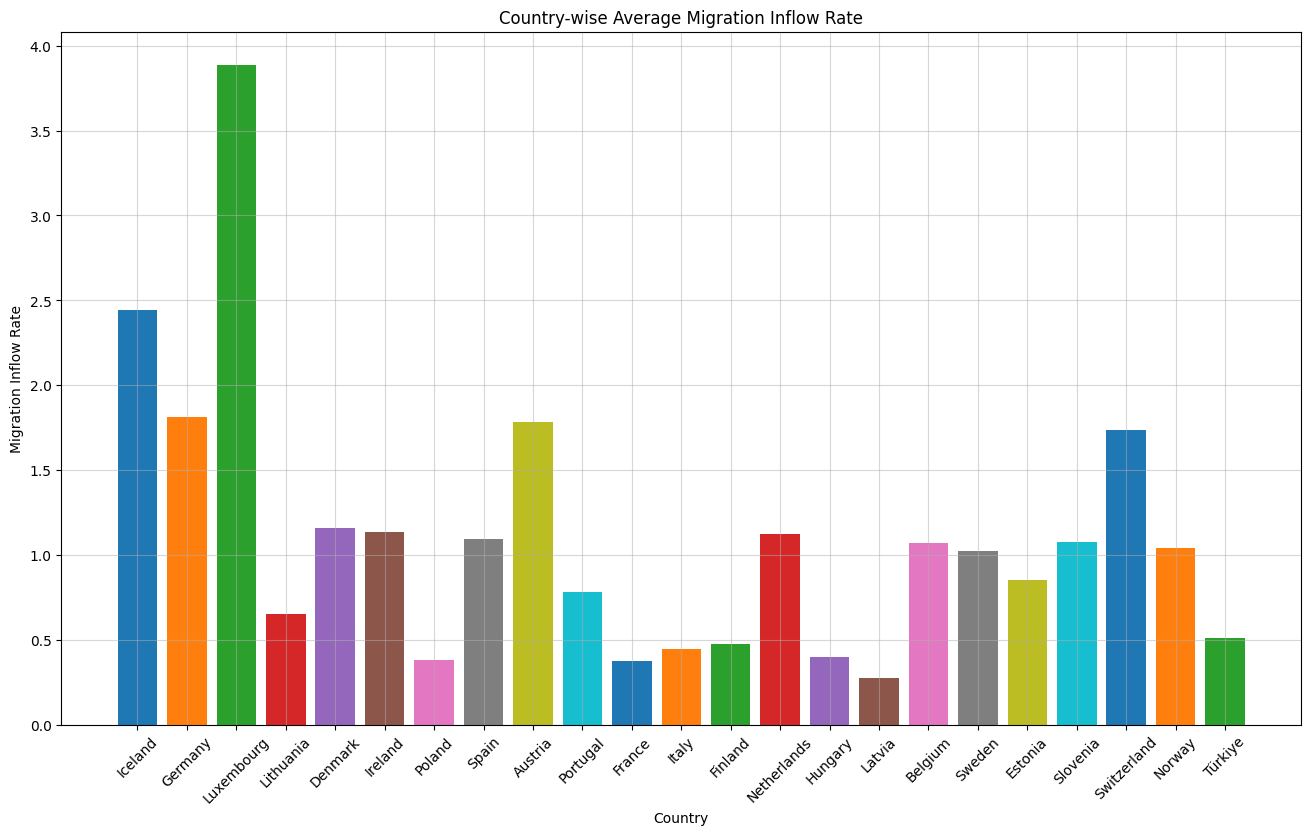

In [7]:
# Plotting the average migration inflow rate of European countries on bar chart
for country in final_dataset['country'].unique():
    country_data = final_dataset[final_dataset['country'] == country]
    plt.bar(country, country_data['migration_inflow_rate'].mean(), label=country)

plt.gcf().set_size_inches(16, 9)
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Migration Inflow Rate')
plt.title('Country-wise Average Migration Inflow Rate')
plt.grid(alpha=0.5)
plt.show()

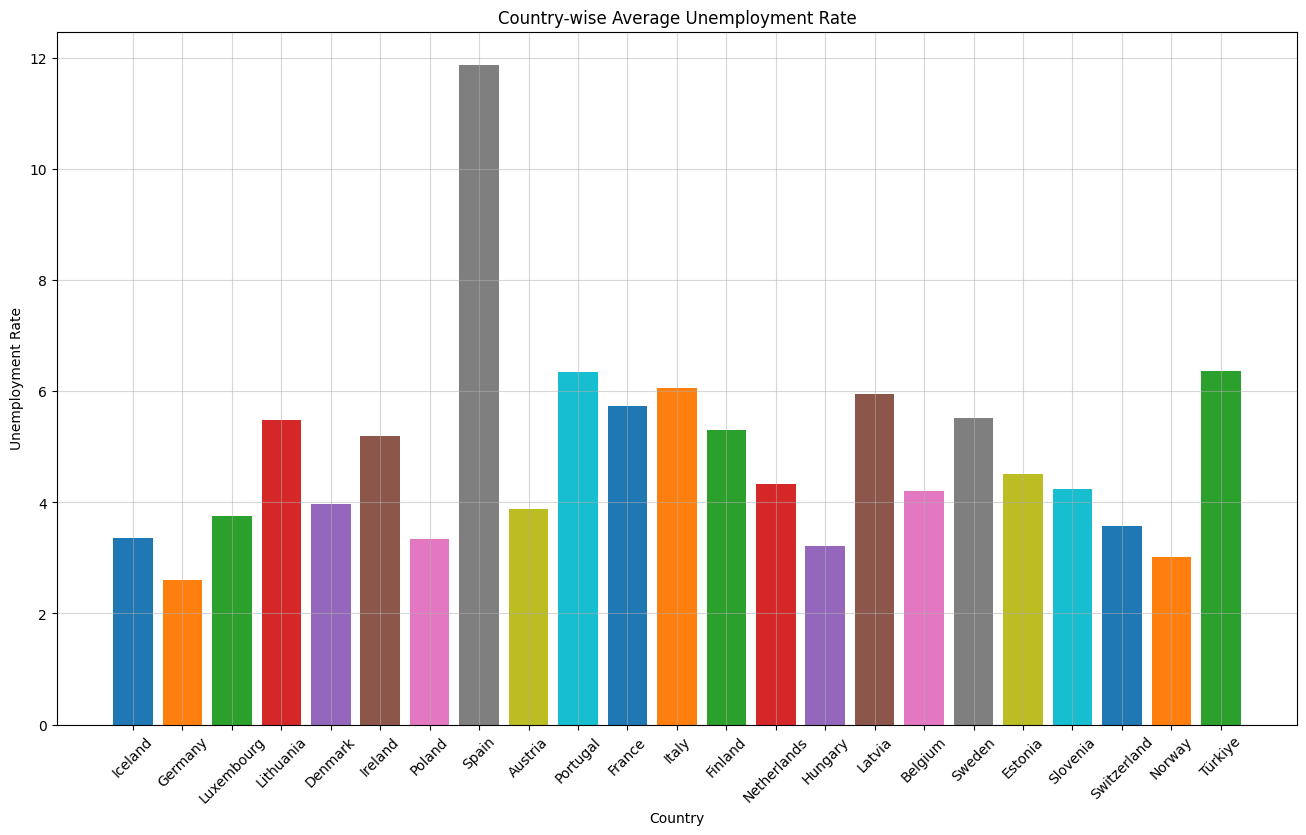

In [8]:
# Plotting the average unemployment rate of European countries on bar chart
for country in final_dataset['country'].unique():
    country_data = final_dataset[final_dataset['country'] == country]
    plt.bar(country, country_data['unemployment_rate'].mean(), label=country)

plt.gcf().set_size_inches(16, 9)
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Unemployment Rate')
plt.title('Country-wise Average Unemployment Rate')
plt.grid(alpha=0.5)
plt.show()

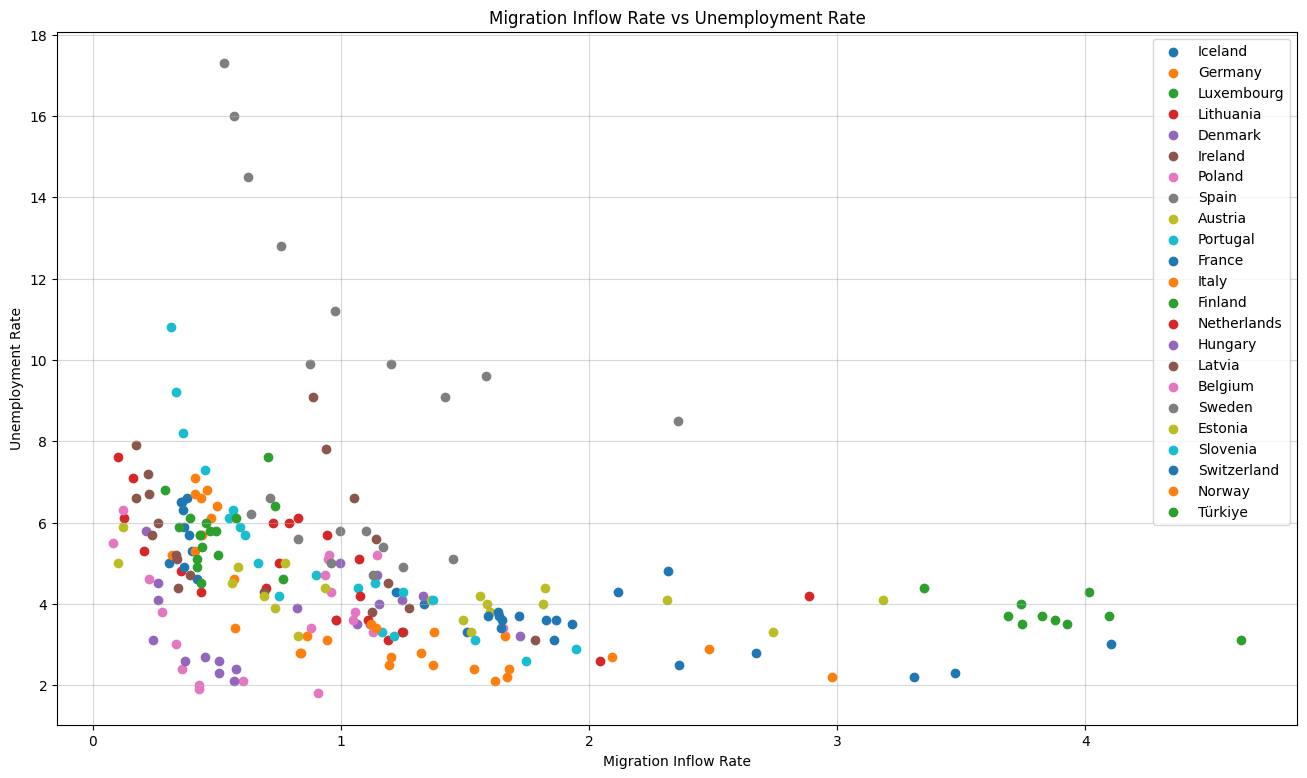

In [9]:
# Plotting the all data points of migration inflow rate vs unemployment rate of European countries on scatter plot
for country in final_dataset['country'].unique():
    country_data = final_dataset[final_dataset['country'] == country]
    plt.scatter(country_data['migration_inflow_rate'], country_data['unemployment_rate'], label=country)
plt.gcf().set_size_inches(16, 9)
plt.xlabel('Migration Inflow Rate')
plt.ylabel('Unemployment Rate')
plt.title('Migration Inflow Rate vs Unemployment Rate')
plt.legend(loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

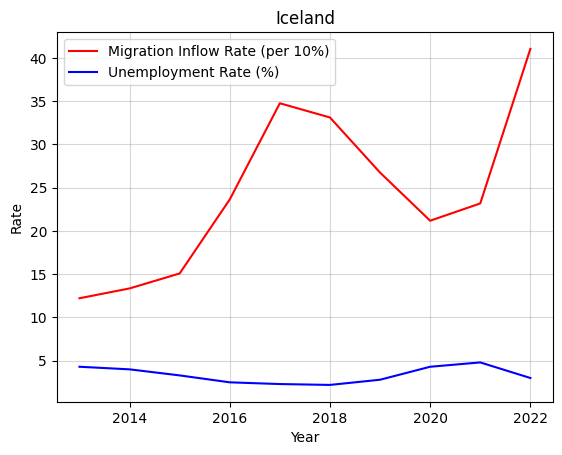

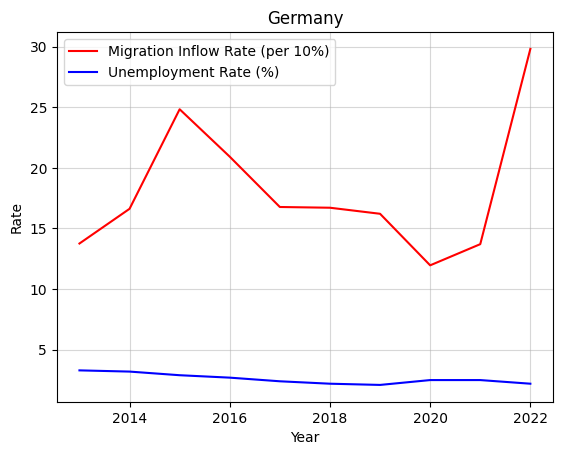

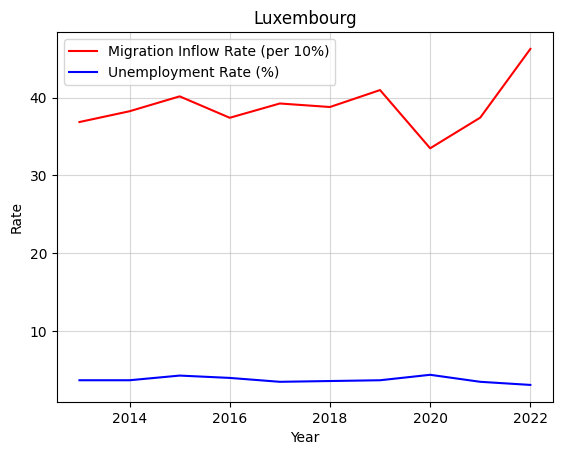

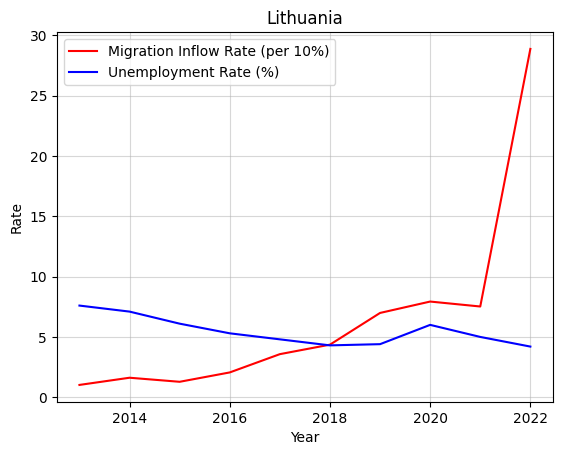

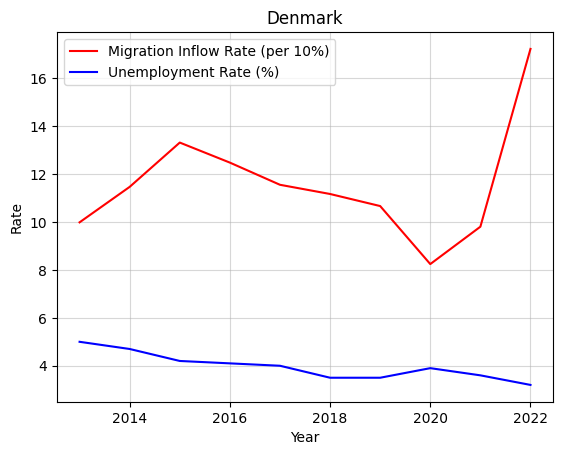

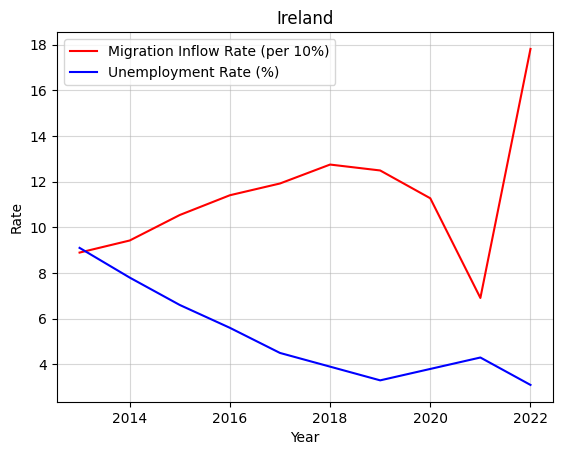

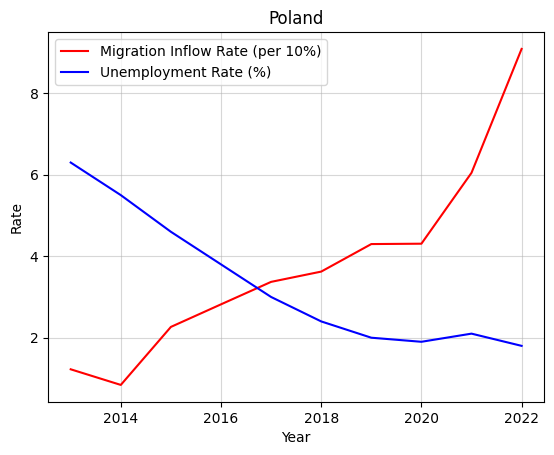

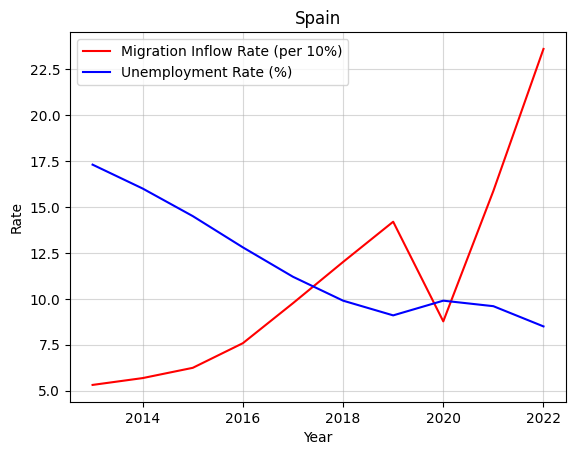

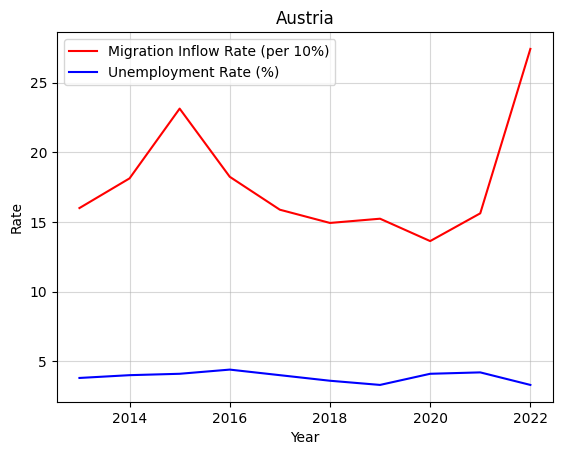

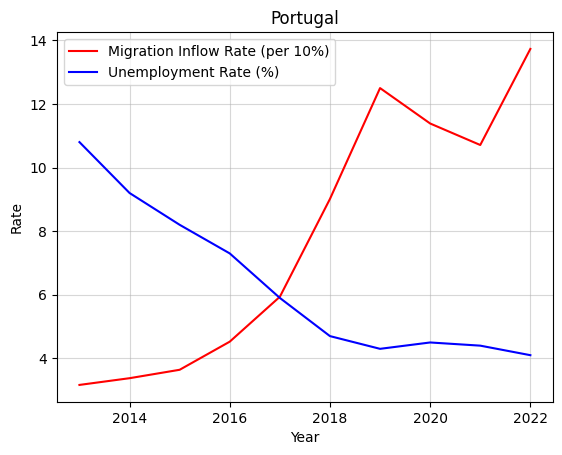

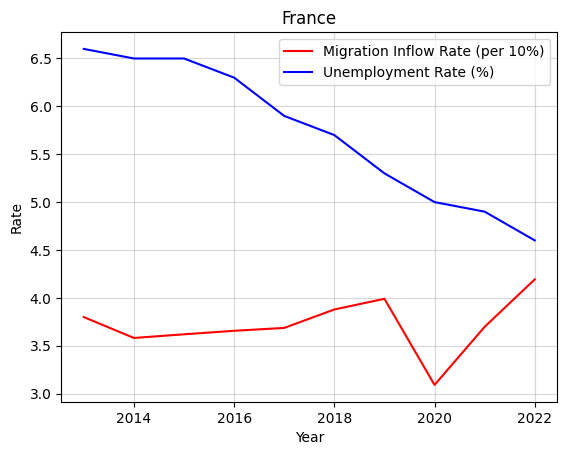

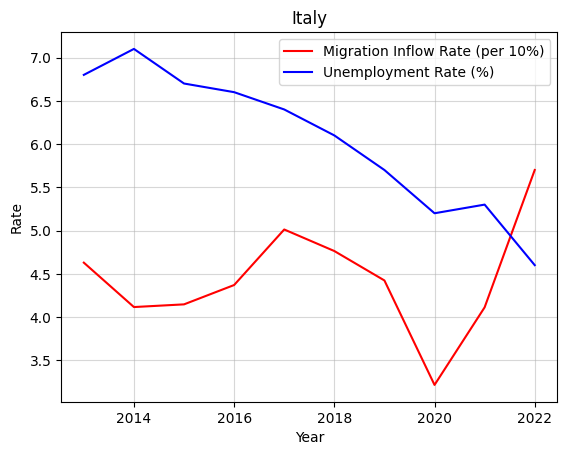

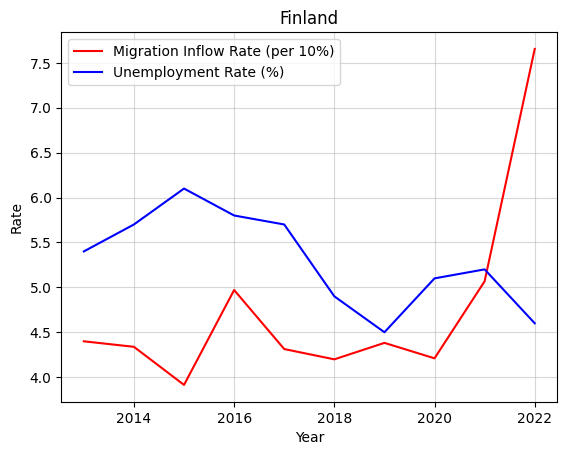

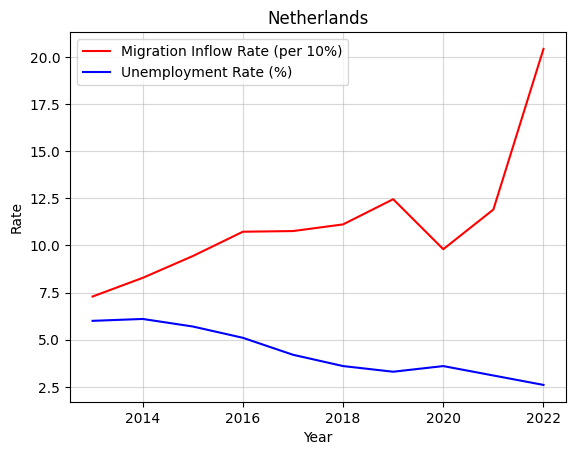

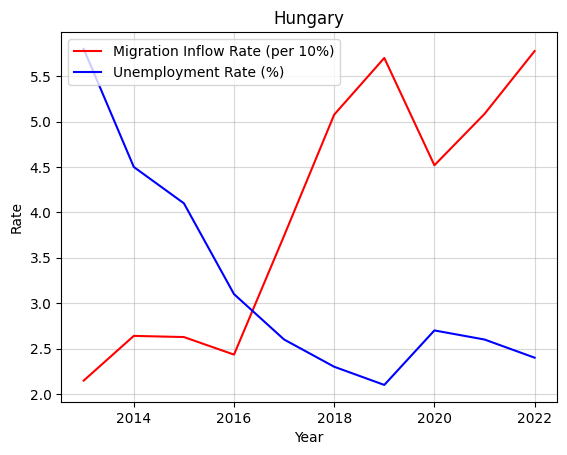

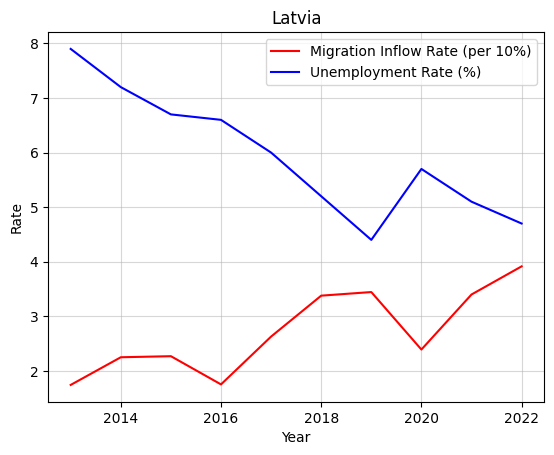

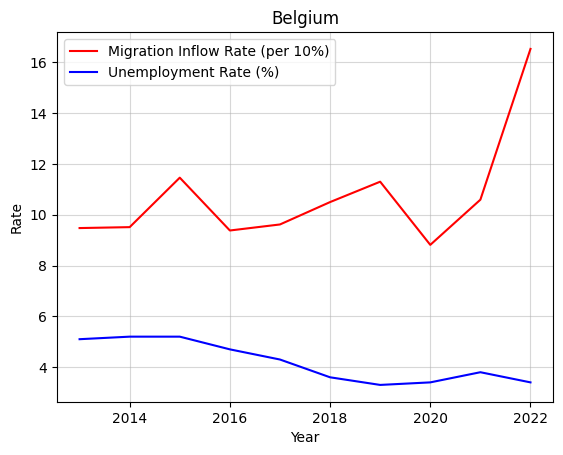

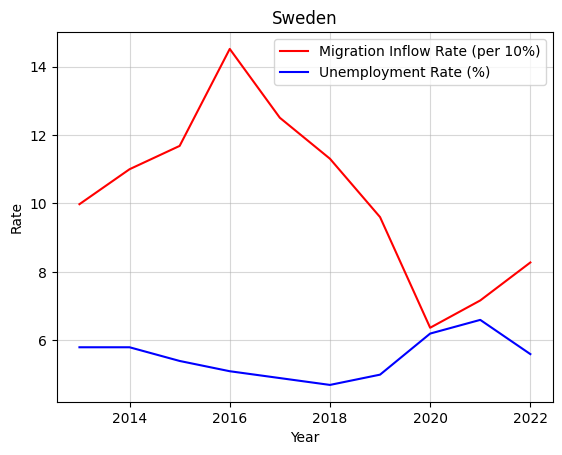

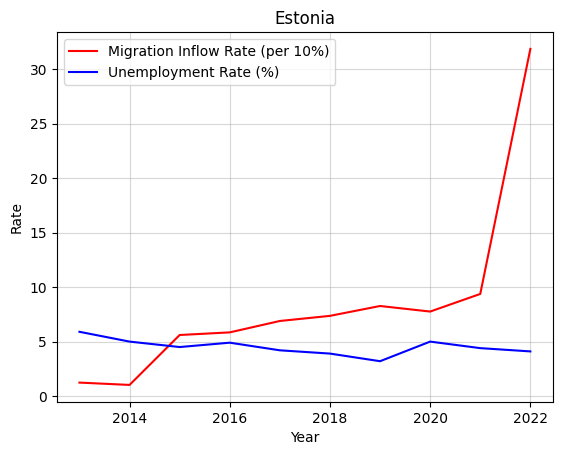

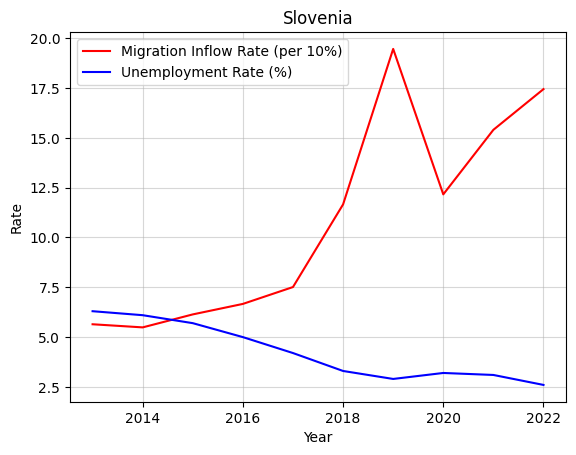

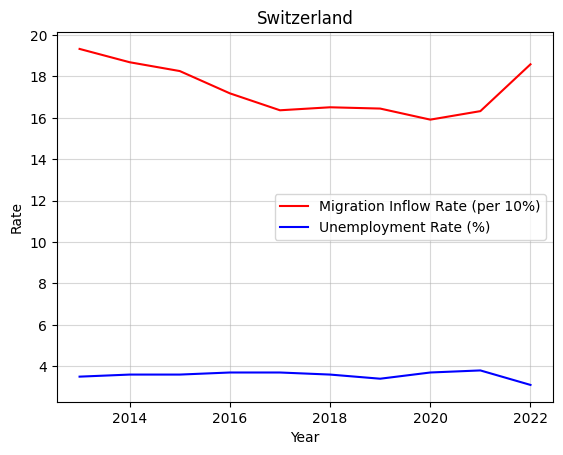

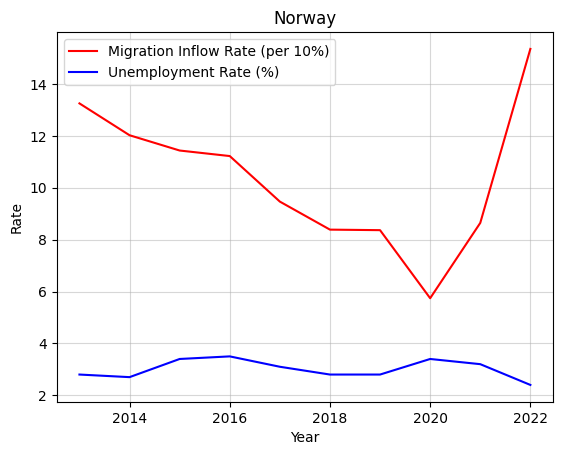

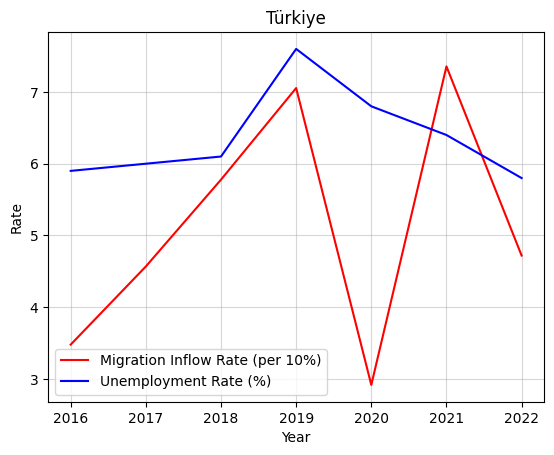

In [10]:
# Plotting the migration inflow rate and unemployment rate for each country
for country in final_dataset['country'].unique():
    country_data = final_dataset[final_dataset['country'] == country]
    plt.plot(
        country_data['year'], 
        country_data['migration_inflow_rate']*10, # per 10% scaling for better visualization
        label="Migration Inflow Rate (per 10%)",
        color='red'
    )

    plt.plot(
        country_data['year'], 
        country_data['unemployment_rate'], 
        label="Unemployment Rate (%)",
        color='blue'
    )
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.legend()
    plt.title(country)
    plt.grid(alpha=0.5)
    plt.show()

# Q1. Is There a Correlation Between Migration Rates and Unemployment Levels in Europe?

### Hypothesis:
As the migration rate increases, the unemployment rate decreases.

## Correlation Analysis

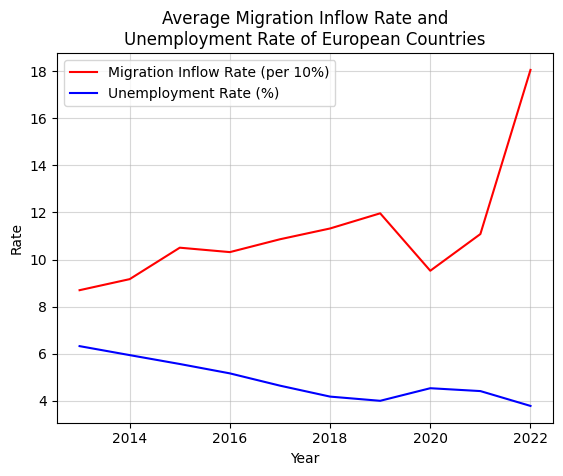

In [11]:
# Plotting the average migration inflow rate and unemployment rate of European countries over time
migration_inflow_data_mean_list = []
migration_outflow_data_mean_list = []
unemployment_data_mean_list = []
years_list = []
for year in final_dataset['year'].unique():
    migration_inflow_data_mean = final_dataset[final_dataset['year'] == year]['migration_inflow_rate'].mean() * 10
    unemployment_data_mean = final_dataset[final_dataset['year'] == year]['unemployment_rate'].mean()
    migration_inflow_data_mean_list.append(migration_inflow_data_mean)
    unemployment_data_mean_list.append(unemployment_data_mean)
    years_list.append(year)
plt.plot(years_list, migration_inflow_data_mean_list, 'r', label='Migration Inflow Rate (per 10%)')
plt.plot(years_list, unemployment_data_mean_list, 'b', label='Unemployment Rate (%)')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Average Migration Inflow Rate and\nUnemployment Rate of European Countries')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

## Correlation Analysis

In [12]:
# Calculation of correlation between migration inflow rate and unemployment rate
total_correlation = 0
print("Correlation between Migration Inflow Rate and Unemployment Rate for each country:")
for country in final_dataset['country'].unique():
    country_data = final_dataset[final_dataset['country'] == country]
    correlation = country_data['migration_inflow_rate'].corr(country_data['unemployment_rate']) # Calculating the correlation between migration inflow rate and unemployment rate for each country
    total_correlation += correlation # Adding the correlation to the total correlation
    print(f"{country}: {correlation}")
print()
print(f"Average Correlation between Migration Inflow Rate and Unemployment Rate: {total_correlation/len(final_dataset['country'].unique())}") # Calculating the average correlation between migration inflow rate and unemployment rate

Correlation between Migration Inflow Rate and Unemployment Rate for each country:
Iceland: -0.6212343864864842
Germany: -0.1671440175891634
Luxembourg: -0.660183268261131
Lithuania: -0.5233723259430396
Denmark: -0.3277582406545401
Ireland: -0.5586197178254549
Poland: -0.8009053676226902
Spain: -0.7980392010133424
Austria: -0.24612800063889848
Portugal: -0.9064813181067877
France: -0.17232391896087412
Italy: -0.15480736589178556
Finland: -0.4581346874517916
Netherlands: -0.7515455731899948
Hungary: -0.8243845500303187
Latvia: -0.9009458313674169
Belgium: -0.3673974994647516
Sweden: -0.726352832397216
Estonia: -0.40402845114845004
Slovenia: -0.8994707842647003
Switzerland: -0.49324458959428974
Norway: -0.5119995972963595
Türkiye: 0.38879035029632586

Average Correlation between Migration Inflow Rate and Unemployment Rate: -0.5167700510827459


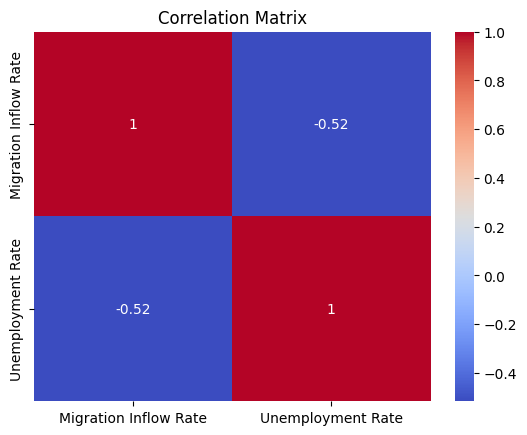

In [13]:
# Calculating and plotting the correlation matrix
columns = ['migration_inflow_rate', 'unemployment_rate']
accumulator_matrix = np.zeros((2, 2))
for country in final_dataset['country'].unique():
    country_data = final_dataset[final_dataset['country'] == country]
    correlation_matrix = country_data[['migration_inflow_rate', 'unemployment_rate']].corr().values
    accumulator_matrix += correlation_matrix
average_correlation_matrix = accumulator_matrix / len(final_dataset['country'].unique())

average_correlation_matrix_df = pd.DataFrame(average_correlation_matrix, index=["Migration Inflow Rate", "Unemployment Rate"], columns=["Migration Inflow Rate", "Unemployment Rate"])

sns.heatmap(average_correlation_matrix_df, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

A correlation matrix revealed a correlation of -0.55 between migration rates and unemployment rates, indicating an inverse relationship. This result, supported by graphs, confirms our hypothesis that higher migration rates are associated with lower unemployment rates. Hypthesis is correct.

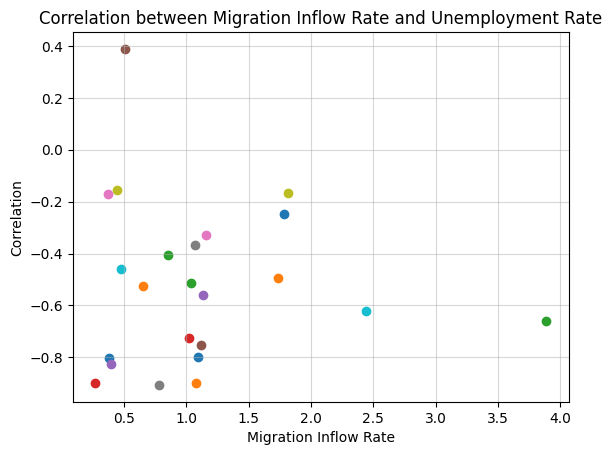

In [14]:
# Calculation of correlation between migration inflow rate and unemployment rate for each country and plotting the correlation on scatter plot
dataset_sorted_by_migration_inflow_rate = final_dataset.copy().sort_values(by='migration_inflow_rate')
for country in dataset_sorted_by_migration_inflow_rate['country'].unique():
    country_data = dataset_sorted_by_migration_inflow_rate[dataset_sorted_by_migration_inflow_rate['country'] == country]
    correlation = country_data[['migration_inflow_rate', 'unemployment_rate']].corr().values
    plt.scatter(country_data['migration_inflow_rate'].mean(), correlation[0][1], label=country)

plt.title('Correlation between Migration Inflow Rate and Unemployment Rate')
plt.xlabel('Migration Inflow Rate')
plt.ylabel('Correlation')
plt.grid(alpha=0.5)
plt.show()

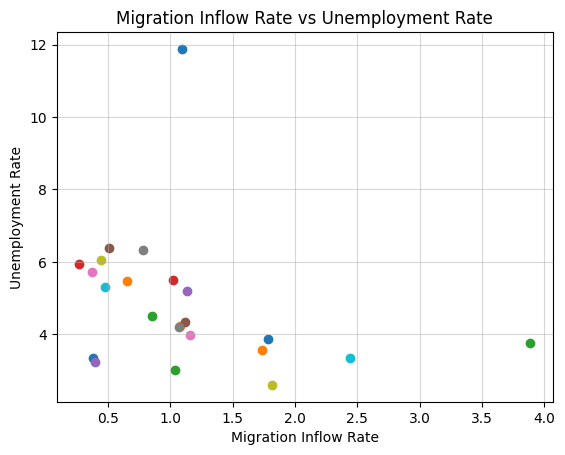

In [15]:
# Calculation of correlation between migration inflow rate and unemployment rate for each country and plotting the correlation on scatter plot
dataset_sorted_by_migration_inflow_rate = final_dataset.copy().sort_values(by='migration_inflow_rate')
for country in dataset_sorted_by_migration_inflow_rate['country'].unique():
    country_data = dataset_sorted_by_migration_inflow_rate[dataset_sorted_by_migration_inflow_rate['country'] == country]
    plt.scatter(country_data['migration_inflow_rate'].mean(), country_data['unemployment_rate'].mean(), label=country)

plt.title('Migration Inflow Rate vs Unemployment Rate')
plt.xlabel('Migration Inflow Rate')
plt.ylabel('Unemployment Rate')
plt.grid(alpha=0.5)
plt.show()


# Q2. Do Countries with Higher Migration Inflows Experience Significant Changes in Unemployment Rates?

### Hypothesis:
Countries with high migration rates exhibit significant changes in unemployment rates.


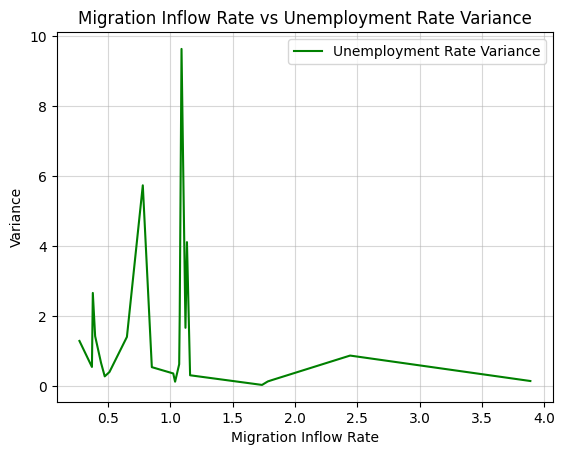

In [16]:
# Calculation of variance of unemployment rate for each country and plotting the variance on scatter plot
migrations = []
unemployment_diffs = []
unemployment_stds = []
unemployment_vars = []
dataset_sorted_by_migration_inflow_rate = final_dataset.copy().sort_values(by='migration_inflow_rate')
for country in dataset_sorted_by_migration_inflow_rate['country'].unique():
    country_data = dataset_sorted_by_migration_inflow_rate[dataset_sorted_by_migration_inflow_rate['country'] == country]
    unemployment_diff = country_data['unemployment_rate'].max() - country_data['unemployment_rate'].min()
    unemployment_var = country_data['unemployment_rate'].var()

    migrations.append(country_data['migration_inflow_rate'].mean())
    unemployment_diffs.append(unemployment_diff)
    unemployment_vars.append(unemployment_var)



# Sorting the data by migration inflow rate to ensure continuous lines
sorted_indices = np.argsort(migrations)
sorted_migrations = np.array(migrations)[sorted_indices]
sorted_unemployment_diffs = np.array(unemployment_diffs)[sorted_indices]
sorted_unemployment_vars = np.array(unemployment_vars)[sorted_indices]

# plt.plot(sorted_migrations, sorted_unemployment_diffs, 'r', label='Unemployment Rate Difference')
plt.plot(sorted_migrations, sorted_unemployment_vars, 'g', label='Unemployment Rate Variance')
plt.xlabel('Migration Inflow Rate')
plt.ylabel('Variance')
plt.title('Migration Inflow Rate vs Unemployment Rate Variance')
plt.grid(alpha=0.5)
plt.legend()
plt.show()


The analysis shows that countries with high migration rates do not exhibit significant changes in unemployment rates, as indicated by the variance and graph.Hypothesis is incorrect.


# Q4. Can Predictive Models Accurately Forecast Migration and Unemployment Trends Based on Historical Migration Data?

### Hypothesis:
Predictive models can accurately forecast migration and unemployment trends.


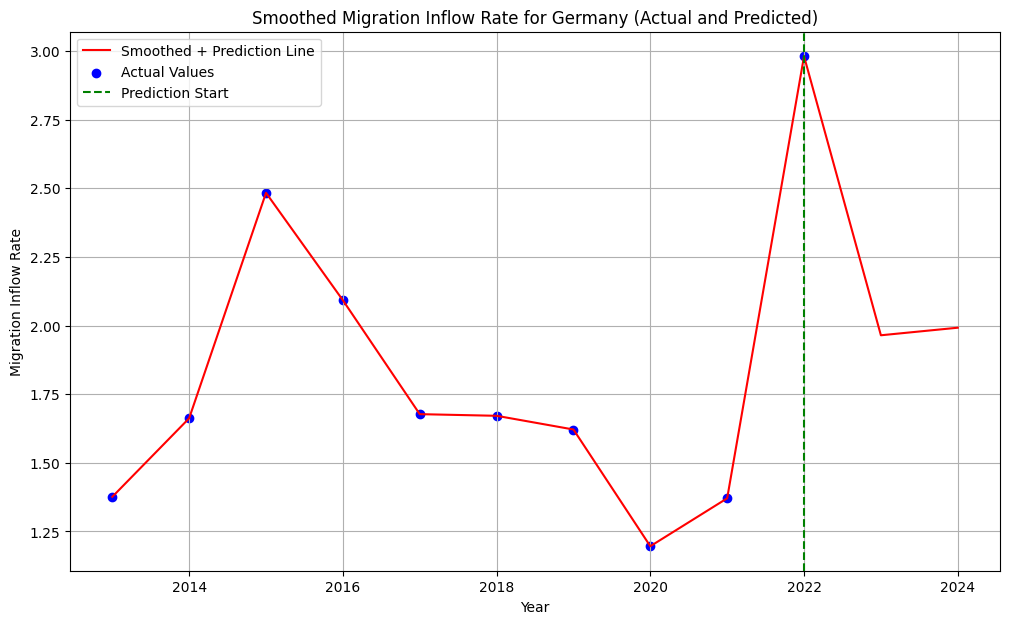

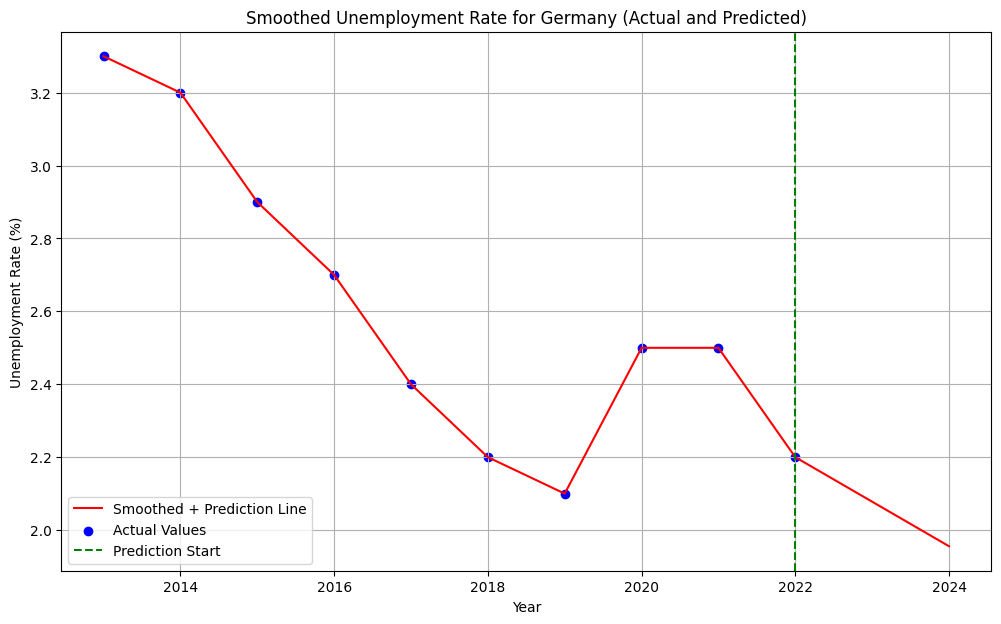

In [17]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Filter the dataset for a specific country (e.g., Germany)
country = 'Germany'
country_data = final_dataset[final_dataset['country'] == country].sort_values('year')

# Convert 'year' column to integers and then to PeriodIndex
country_data['year'] = country_data['year'].astype(int)
country_data = country_data.set_index(pd.PeriodIndex(country_data['year'], freq='Y'))
country_data.drop(columns=['year'], inplace=True)  # Remove 'year' as it's now the index

# Smoothing using Exponential Smoothing for Migration Inflow Rate
smoothed_migration = ExponentialSmoothing(
    country_data['migration_inflow_rate'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()

# Forecast next 2 years
forecast_index = pd.period_range(start=country_data.index[-1] + 1, periods=2, freq='Y')
migration_smooth_forecast = pd.Series(smoothed_migration.forecast(steps=2), index=forecast_index)

# Smoothing using Exponential Smoothing for Unemployment Rate
smoothed_unemployment = ExponentialSmoothing(
    country_data['unemployment_rate'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()

# Forecast next 2 years
unemployment_smooth_forecast = pd.Series(smoothed_unemployment.forecast(steps=2), index=forecast_index)

# Combine smoothed forecasts
smooth_forecast_data = pd.DataFrame({
    'year': forecast_index.year,  # Extract year from PeriodIndex correctly
    'migration_inflow_rate': migration_smooth_forecast.values,
    'unemployment_rate': unemployment_smooth_forecast.values
})

# Reset index of historical data and add a 'year' column
country_data_reset = country_data.reset_index()
country_data_reset['year'] = country_data_reset['year'].dt.year  # Use the reset index to extract the year

# Append smoothed forecasts to historical data
smoothed_combined_data = pd.concat([
    country_data_reset,
    smooth_forecast_data
], ignore_index=True)

# Plot Migration Inflow Rate with smoothed forecasts
plt.figure(figsize=(12, 7))
plt.plot(smoothed_combined_data['year'], smoothed_combined_data['migration_inflow_rate'], color='red', label='Smoothed + Prediction Line')
plt.scatter(country_data_reset['year'], country_data_reset['migration_inflow_rate'], color='blue', label='Actual Values')
plt.axvline(x=country_data_reset['year'].iloc[-1], color='green', linestyle='--', label='Prediction Start')
plt.title(f'Smoothed Migration Inflow Rate for {country} (Actual and Predicted)')
plt.xlabel('Year')
plt.ylabel('Migration Inflow Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot Unemployment Rate with smoothed forecasts
plt.figure(figsize=(12, 7))
plt.plot(smoothed_combined_data['year'], smoothed_combined_data['unemployment_rate'], color='red', label='Smoothed + Prediction Line')
plt.scatter(country_data_reset['year'], country_data_reset['unemployment_rate'], color='blue', label='Actual Values')
plt.axvline(x=country_data_reset['year'].iloc[-1], color='green', linestyle='--', label='Prediction Start')
plt.title(f'Smoothed Unemployment Rate for {country} (Actual and Predicted)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


The prediction failed because the model couldn't capture nonlinear trends or external influences. Exponential Smoothing assumes linear patterns and stationarity, which the data didn't fully meet. Overfitting or oversimplifying trends led to unrealistic forecasts, and the absence of external factors like economic or policy changes further reduced the model's accuracy.

# Potential Products or Services

- **Policy Insights Platform**: A subscription-based platform offering real-time migration and unemployment insights to policymakers, researchers, and international organizations.
- **Economic Impact Dashboard**: An interactive online tool displaying trends and correlations between migration rates and unemployment levels across Europe.

---
# Issues Related to Data Engineering

- **Data Integration**: Seamlessly integrating datasets from various sources (e.g., Eurostat, OECD) with differing formats, frequencies, and standards.
- **Data Quality**: Managing missing, inconsistent, or inaccurate data that could impact model outputs and user trust.
- **Scalability**: Building an infrastructure capable of handling growing data volumes and increasing user demands.

---

# Issues Related to Ethics

- **Privacy Concerns**: Protecting individual and demographic-level data from misuse or breaches.
- **Bias in Data**: Addressing dataset biases that may result in inaccurate or discriminatory outcomes.
- **Informed Consent**: Ensuring ethical data usage with permissions and guidelines for sensitive or restricted data.
- **Impact on Public Perception**: Preventing misuse of findings to support xenophobic or discriminatory policies.
- **Transparency**: Clearly communicating the limitations and assumptions of analyses to avoid misleading stakeholders.

---

# Conclusion

Key outcomes of this project include:
- Developing a comprehensive framework to analyze migration and unemployment trends.
- Highlighting regional variations across Europe using robust statistical methods.
- Providing actionable insights to help policymakers and researchers address labor market challenges.
